#### Houmch - houmaanch@gmail.com

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency 
pd.options.mode.chained_assignment = None
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid")

### A- Reading input into dataframe:
For a detailed description on each of these columns, please refer to the task desciption provided in a separate file.

In [2]:
df = pd.read_csv('adjust_sampled_data.csv', index_col=0)
df['installed_at'] = pd.to_datetime(df['installed_at'])
df['created_at'] = pd.to_datetime(df['created_at'])
df.drop_duplicates(inplace=True)
df.head()

,adid,network_name,installed_at,activity_kind,event_name,created_at
0,1dcedd19b197650bd08a1f521caa3f8b,Organic,2019-07-06 00:07:04,event,get_contact,2019-07-08 15:33:44
1,d621e1bfa590881a68581733052dce57,Organic,2019-07-06 00:14:50,event,get_contact,2019-07-08 15:53:04
2,7107c045edc8eb4740ea7d8d7fd0b4aa,Organic,2019-07-06 00:33:40,event,new_post_submit,2019-07-08 10:24:14
3,32a53ff379ace92a650f0a41f1d02af1,Organic,2019-07-06 02:33:10,event,get_contact,2019-07-08 09:21:11
4,1eaeca850ef726e6c12475e099a9d9de,Organic,2019-07-06 03:28:56,event,get_contact,2019-07-06 14:00:28


### B- Defining some dataframes and lists:
These dataframes and lists will help us in upcoming sections.

In [5]:
not_event_df = df[df.activity_kind != 'event']
df_nodup = df.drop_duplicates(subset=['adid'])
install_df = not_event_df[not_event_df.activity_kind == 'install']
valid_net_names = ['Organic', 'Tapsell', 'Adwords UAC Installs', 'Cafebazaar-searchad']
valid_event_names = ['get_contact', 'new_post_submit', np.nan]

### C- Data exploration:
We should eliminate all rows that their activity kind is 'uninstall' and their timestamp ('create_at') is after the first uninstall for each user, since we only have one activity named 'install' for each user in our data

In [7]:
uninstall_df = df[df.activity_kind == 'uninstall']
uninstall_df.drop_duplicates(subset=['adid'], inplace=True, keep='first')

df = df[df.activity_kind != 'uninstall']
df = df.append(uninstall_df)

grouped_by_adid = df.groupby(['adid'])
forcheck_df = grouped_by_adid['activity_kind'].value_counts().unstack(level=1)
sorted_df = df.sort_values(by=['adid', 'created_at'], ascending = True)

Some adid's does not have a row containing 'install' event. But it is fine since there is a column for it. There are 6732 unique entities with this issue.

In [8]:
len(forcheck_df[forcheck_df['install'].isnull()].index.unique())

6723

All entites either has one install time or none. Of those 6732 that does not have row with event == 'install', all entites has only got one 'installed_at' value. So all users has got only one 'install dt' value.

In [9]:
install_nan_adids = forcheck_df[forcheck_df['install'].isnull()].index.to_list()
selected_elements = sorted_df[sorted_df.adid.isin(install_nan_adids)].groupby(['adid'])['installed_at'].unique().values
selected_elements.shape

(6723,)

### D- Pre checkings:

In [17]:
print("Event name present for all rows with activity_kind = ~event~")
assert(df[df.activity_kind == 'event'].event_name.isna().sum() == 0)
print('----------------------------------------------------------------')
print("Event name is null for all rows with activity_kind != ~event~")
assert(not_event_df.event_name.isna().sum() == len(not_event_df.index))
print('----------------------------------------------------------------')
print("Network name should only be specific elements")
assert(set(df['network_name'].unique()) == set(valid_net_names))
print('----------------------------------------------------------------')
print("Event name should only be specific elements")
assert(set(df['event_name'].unique()) == set(valid_event_names))
print('----------------------------------------------------------------')
print("installed_at and created_at must be equal when activity_kind = ~install~")
assert(install_df['installed_at'].equals(install_df['created_at']))
print('----------------------------------------------------------------')
print("All uninstall dates should be further away from install date")
assert(len(uninstall_df[uninstall_df['created_at'].lt(uninstall_df['installed_at'])].index) == 0)

Event name present for all rows with activity_kind = ~event~
----------------------------------------------------------------
Event name is null for all rows with activity_kind != ~event~
----------------------------------------------------------------
Network name should only be specific elements
----------------------------------------------------------------
Event name should only be specific elements
----------------------------------------------------------------
installed_at and created_at must be equal when activity_kind = ~install~
----------------------------------------------------------------
All uninstall dates should be further away from install date


## 1:
### 1-1:
In this part, we will try to measure percentage of users who have performed at least one activity from kinds **get_contact** and **new_post_submit** in the three day period following their signup.

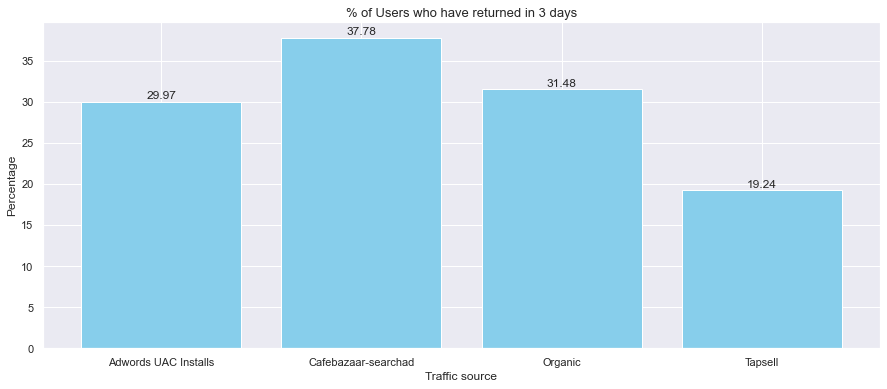

In [22]:
event_df = df[df.activity_kind == 'event']
event_df['timedelta'] = event_df['created_at'] - event_df['installed_at']
temp_df = event_df.groupby(['adid']).min()
valid_adids = temp_df[temp_df['timedelta'].dt.days < 3].index.to_list()

target_df = event_df[event_df['adid'].isin(valid_adids)].drop_duplicates(subset=['adid'])

metric1_values = target_df.groupby(['network_name']).count()['adid']
usercount_per_network = df.groupby(['network_name'])['adid'].unique()

percentage_series = metric1_values / usercount_per_network.str.len()
x_axis = percentage_series.index
y_axis = percentage_series.values * 100

plt.figure(figsize=(15, 6))
plt.bar(x_axis,y_axis, color='skyblue')
plt.xlabel("Traffic source", size=12)
plt.ylabel("Percentage", size=12)
plt.title('% of Users who have returned in 3 days', size=13)
for x,y in zip(x_axis,y_axis):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,3),
                 ha='center')

### 1-2:
We should redefine 'target' here. There are some users that we do not have enough data for them and their entries must be deleted.Specially those who do not have a lifetime of 30 days or more.

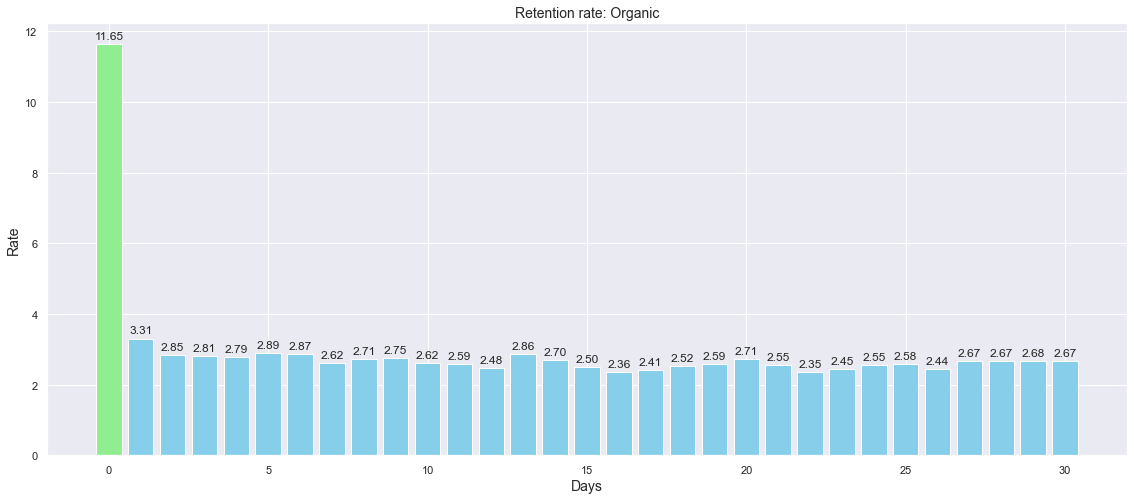

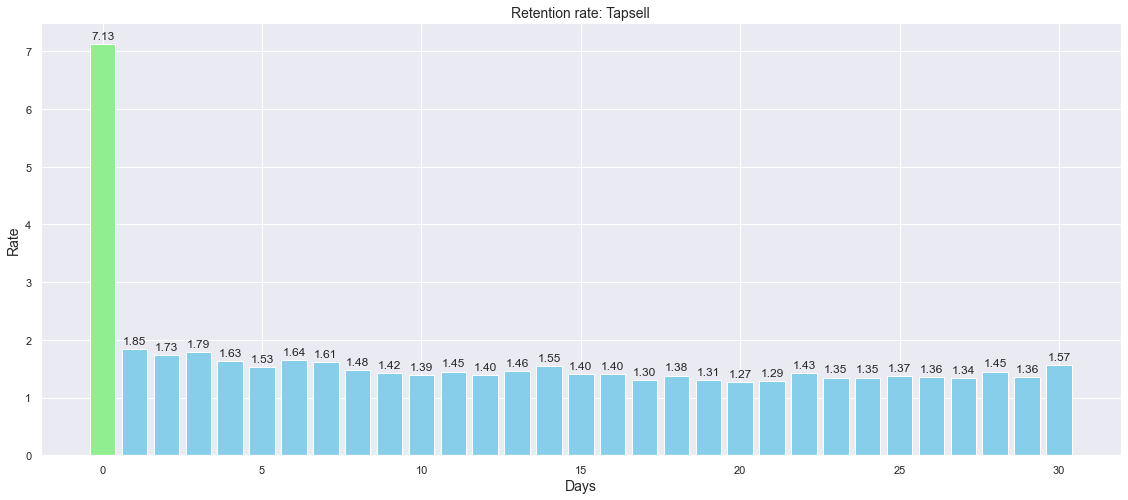

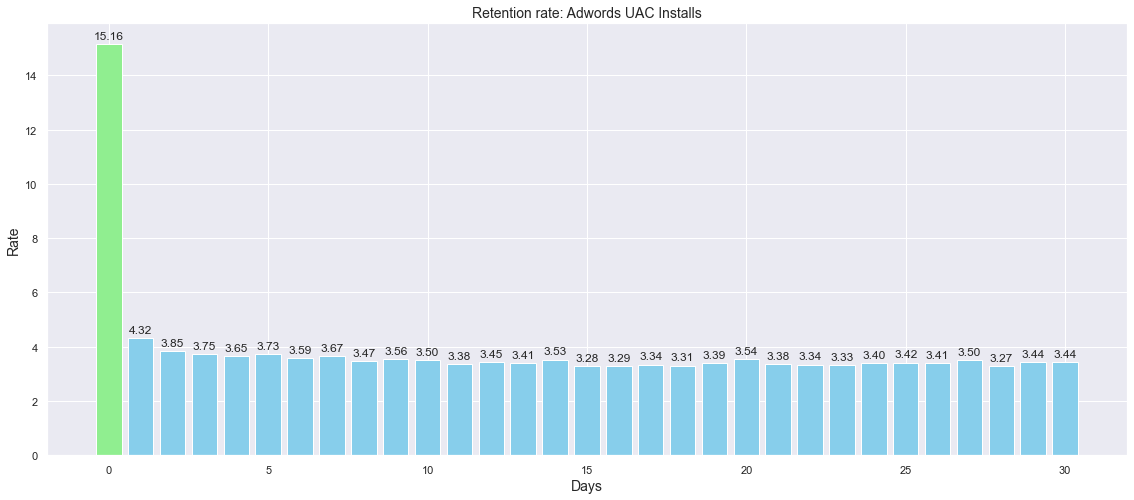

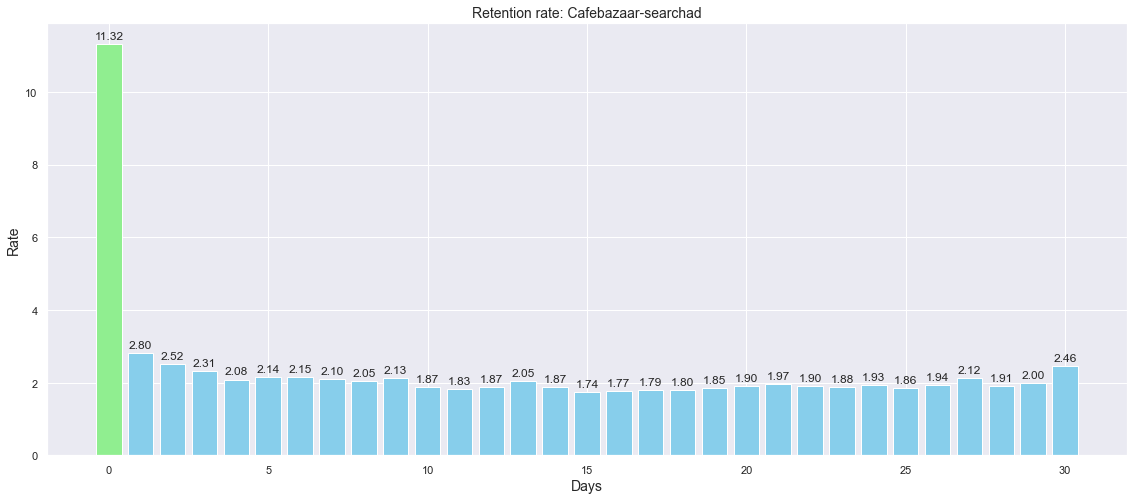

In [25]:
def set_color(inp_lst):
    colors = []
    for i in inp_lst:
        if i<5:
            colors.append('skyblue')
        elif i>=3:
            colors.append('lightgreen')
    return colors
    

temp2_df = event_df.groupby(['adid']).max()
new_valid_adids = temp2_df[temp2_df['timedelta'].dt.days >= 30].index.to_list()
target_df = event_df[event_df['adid'].isin(new_valid_adids)]

first_event_df = target_df.groupby(['adid']).min()[['created_at']]
first_event_df['adid'] = first_event_df.index
first_event_df.columns = ['first_event_at', 'adid']
first_event_df.index.names = ['index']

merged_target_df = pd.merge(target_df, first_event_df, on='adid')
merged_target_df['timedelta_2'] = (merged_target_df['created_at'] - merged_target_df['first_event_at']).dt.days
merged_target_df.drop_duplicates(subset=['adid', 'timedelta_2'], inplace=True)

all_x_axis = []
all_y_axis = []
retention_gp = merged_target_df.groupby(['network_name'])['timedelta_2']
for i in valid_net_names:
    count_dict = Counter(retention_gp.get_group(i).to_list())
    net_size = len(usercount_per_network[i])
    x_axis = []
    y_axis = []
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_axes([0,0,1,1])
    for j in range(31):
        x_axis.append(j)
        y_axis.append(100 * count_dict[j] / net_size)
    all_x_axis.append(x_axis)
    all_y_axis.append(y_axis)
    plt.bar(x_axis,y_axis, color=set_color(y_axis))
    for x,y in zip(x_axis,y_axis):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,5),
                     ha='center')
    plt.xlabel("Days", size=14)
    plt.ylabel("Rate", size=14)
    plt.title('Retention rate: {}'.format(i), size=14)
    plt.show()

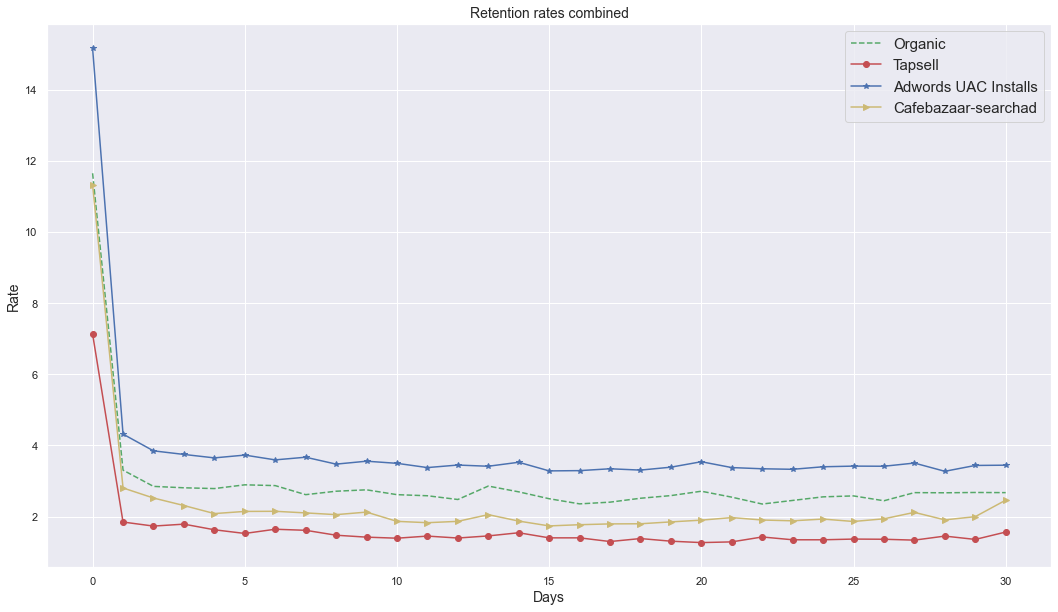

In [27]:
plt.figure(figsize=(18, 10))
plt.plot(all_x_axis[0],all_y_axis[0], 'g--', label= valid_net_names[0])
plt.plot(all_x_axis[1],all_y_axis[1], 'r-o', label= valid_net_names[1])
plt.plot(all_x_axis[2],all_y_axis[2], 'b-*', label= valid_net_names[2])
plt.plot(all_x_axis[3],all_y_axis[3], 'y->', label= valid_net_names[3])
plt.xlabel("Days", size=14)
plt.ylabel("Rate", size=14)
plt.title('Retention rates combined', size=14)
plt.legend(prop={'size': 15})

## 2:
### 2-1:
For visualization purposes, installation datetime values have been grouped into 5 minute intervals.

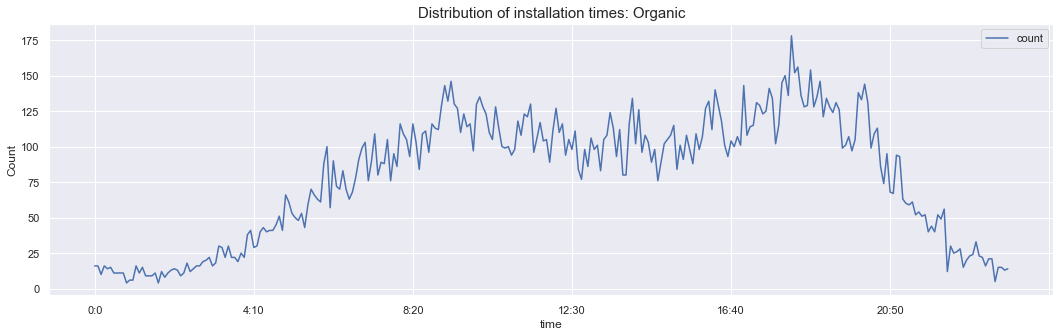

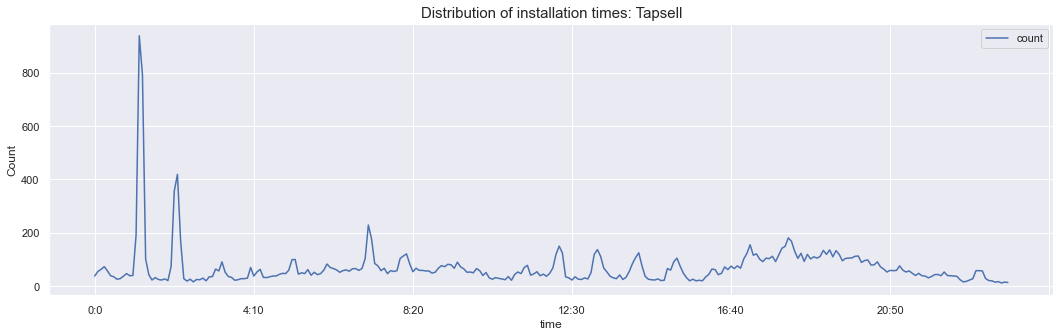

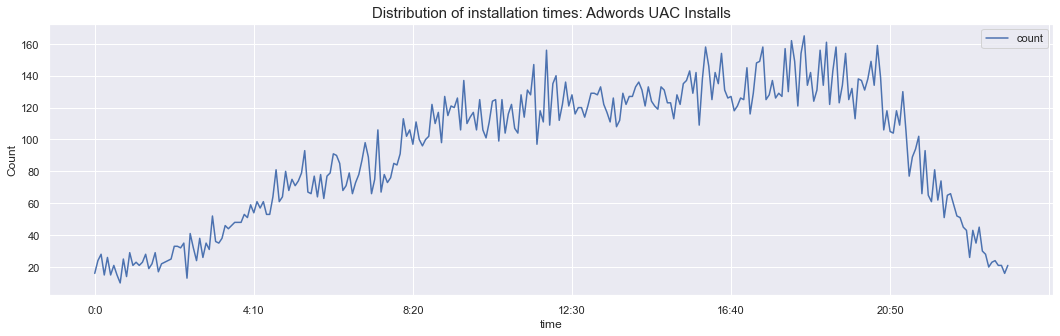

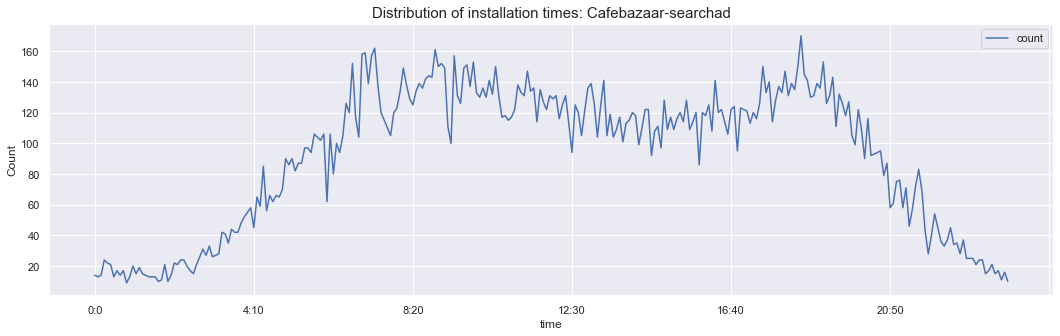

In [93]:
df_nodup['install_h'] = df_nodup['installed_at'].dt.hour
df_nodup['install_m'] = df_nodup['installed_at'].dt.minute
df_nodup['install_m'] = df_nodup['install_m'].apply(lambda x: int(x / 5)*5)
grouped = df_nodup.groupby(['network_name'])
fig_index = 1
for i in valid_net_names:
    current_gp_df = grouped.get_group(i)
    a = current_gp_df.groupby(['install_h', 'install_m']).count()['adid']
    a = a.reset_index(level=[0,1])
    a['time'] = a['install_h'].astype(str) + ':' + a['install_m'].astype(str)
    del a['install_h'], a['install_m']
    a.set_index('time', inplace=True)
    a.columns = ['count']
    a.plot(figsize=(18, 5))
    plt.title('Distribution of installation times: {}'.format(i), size=15)
    plt.ylabel('Count')
    plt.show()
    fig_index += 1


### 2-2:
For this part, we have excluded those users that does not have a row with an event (get_contact or submit). After plotting distribution of days between actions, it's clear that more than 80% of values are within 1 day. So only those timeintervals LQ than 1 days will be considered.

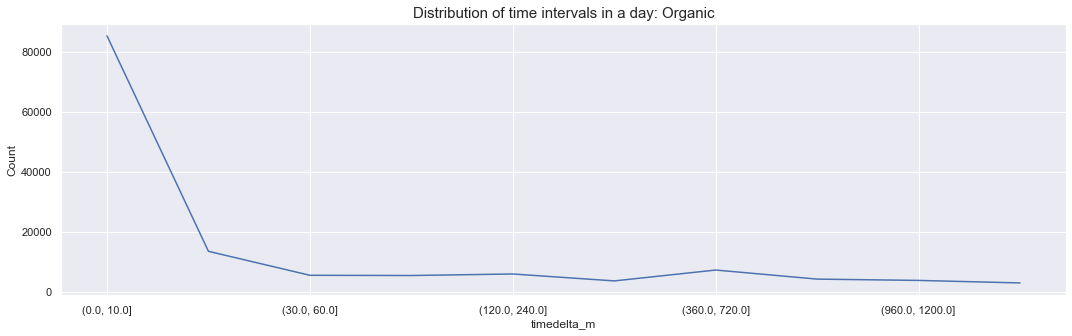

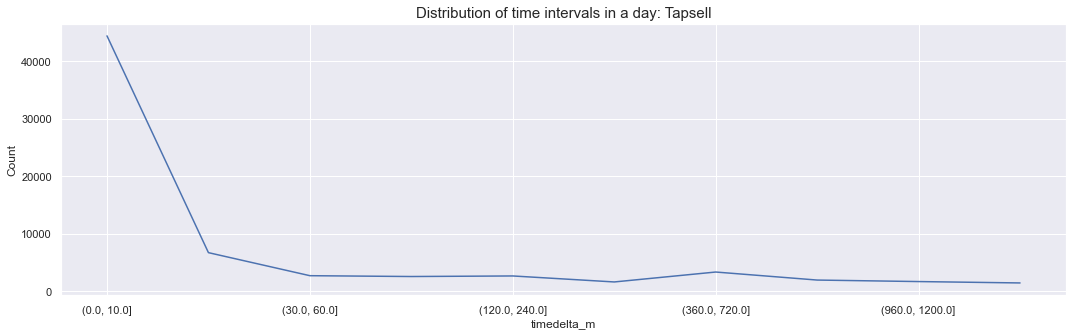

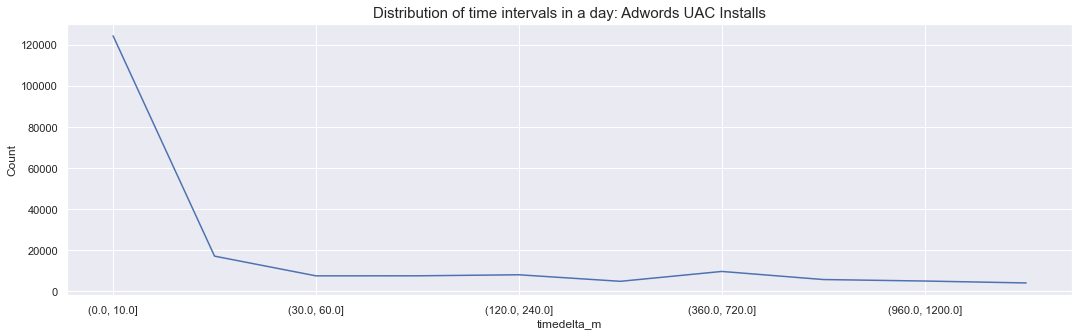

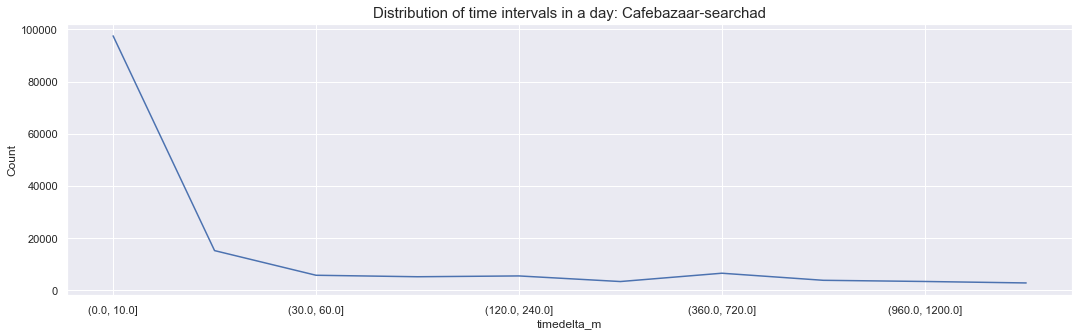

In [73]:
range_list = [0, 10, 30, 60, 120, 240, 360, 720,
              960, 1200, np.inf]
valid_adids = forcheck_df[forcheck_df['event'].notnull()].index.to_list()
for i in valid_net_names:
    modified_sorted_df = sorted_df[sorted_df.adid.isin(valid_adids)]
    modified_sorted_df = modified_sorted_df[modified_sorted_df['network_name'] == i]
    modified_sorted_df['timedelta'] = modified_sorted_df.created_at.diff()
    modified_sorted_df['timedelta'] = np.where(modified_sorted_df['adid'] == modified_sorted_df['adid'].shift(1), 
                                              modified_sorted_df['timedelta'], np.nan)
    
    modified_sorted_df['timedelta_h'] = modified_sorted_df['timedelta'].dt.total_seconds()/3600
    modified_sorted_df['timedelta_m'] = modified_sorted_df['timedelta'].dt.total_seconds()/60
    modified_sorted_df = modified_sorted_df[(modified_sorted_df['activity_kind'] == 'event') & 
                                           (modified_sorted_df['timedelta_h'] <= 23)]
    
    a = modified_sorted_df.groupby(pd.cut(modified_sorted_df['timedelta_m'], 
                                          np.array(range_list))).count().adid
    a.plot(figsize=(18, 5))
    plt.title('Distribution of time intervals in a day: {}'.format(i), size=15)
    plt.ylabel('Count')
    plt.show()

## 3:
As shown below, Final value must be calculated by "total_points"/"install_count". Normalization is essential here.

In [32]:
event_df['value'] = np.where(event_df['event_name'] == 'get_contact', 10,
                            np.where(event_df['event_name'] == 'new_post_submit', 100, 0))
event_gp = event_df.groupby(['network_name'])
value_series = event_gp.value.sum().sort_values(ascending = False)
costs_series = event_gp.adid.nunique()
value_df = pd.concat([value_series, costs_series], axis=1)
value_df.columns = ['total_points', 'install_count']
value_df['resulting_value'] = value_df['total_points'] / value_df['install_count']
value_df.sort_values(by=['resulting_value'], ascending=False)

,total_points,install_count,resulting_value
Adwords UAC Installs,4505060,14714,306.175071
Organic,3311950,11627,284.849918
Tapsell,1589060,6393,248.562490
Cafebazaar-searchad,3121520,14894,209.582382


## 4:

<h3> <mark>first method:</mark></h3> 
Consider distribution of each amount of 'new_post' or 'get_contact' per user, calculate diff with all_df and other network, average all values to report a weighted average improvement in that category.As we can see, using this method to consider impact, tapsell does not seem to be doing much better than others in get_contact and Adwords has improved about 3.5 percent compared to all networks in terms of post_submit.

In [128]:
tapsell_df = df[df['network_name'] == 'Tapsell']
adwords_df = df[df['network_name'] == 'Adwords UAC Installs']

all_series = df.groupby(['adid'])['event_name'].value_counts()
tap_series = tapsell_df.groupby(['adid'])['event_name'].value_counts()
ad_series = adwords_df.groupby(['adid'])['event_name'].value_counts()

all_event_counts = all_series.unstack(level=1)
all_event_counts.fillna(0, inplace=True)
tap_event_counts = tap_series.unstack(level=1)
tap_event_counts.fillna(0, inplace=True)
add_event_counts = ad_series.unstack(level=1)
add_event_counts.fillna(0, inplace=True)


##-------------------------------------------- new_post_submit -------------------------------------------
ad_post_submit = add_event_counts['new_post_submit'].value_counts() / len(add_event_counts.index) * 100
all_post_submit = all_event_counts['new_post_submit'].value_counts() / len(all_event_counts.index) * 100
tap_post_submit = tap_event_counts['new_post_submit'].value_counts() / len(tap_event_counts.index) * 100

nps_comp = pd.concat([ad_post_submit.rename('nps_adwords'), 
                      all_post_submit.rename('nps_all'), tap_post_submit.rename('nps_tap')], axis=1).reset_index()
del nps_comp['index']
nps_comp.fillna(0, inplace=True)

nps_comp['diff_to_all'] = (nps_comp['nps_adwords'] - nps_comp['nps_all']) * nps_comp['nps_adwords'] / 100 
nps_comp['diff_to_all'][0] = -(nps_comp['diff_to_all'][0])
nps_adall_point = nps_comp['diff_to_all'].mean()

nps_comp['diff_to_tap'] = (nps_comp['nps_adwords'] - nps_comp['nps_tap']) * nps_comp['nps_adwords'] / 100 
nps_comp['diff_to_tap'][0] = -(nps_comp['diff_to_tap'][0])
nps_adtap_point = nps_comp['diff_to_tap'].mean()

print('Relative improvement of Adwords in post_submit compared to all networks: ', nps_adall_point * 100)
print('Relative improvement of Adwords in post_submit compared to Tapsell: ', nps_adtap_point * 100)
print('--------------------------------------------')

##-------------------------------------------- get_contact -------------------------------------------
ad_get_contact = add_event_counts['get_contact'].value_counts() / len(add_event_counts.index) * 100
all_get_contact = all_event_counts['get_contact'].value_counts() / len(all_event_counts.index) * 100
tap_get_contact = tap_event_counts['get_contact'].value_counts() / len(tap_event_counts.index) * 100

get_comp = pd.concat([ad_get_contact.rename('get_adwords'), 
                      all_get_contact.rename('get_all'), tap_get_contact.rename('get_tap')], axis=1).reset_index()
del get_comp['index']
get_comp.fillna(0, inplace=True)

get_comp['diff_to_all'] = (get_comp['get_tap'] - get_comp['get_all']) * get_comp['get_tap'] / 100
get_comp['diff_to_all'][0] = -(get_comp['diff_to_all'][0])
get_tapall_point = get_comp['diff_to_all'].mean() * 100

get_comp['diff_to_ad'] = (get_comp['get_tap'] - get_comp['get_adwords']) * get_comp['get_tap'] / 100
get_comp['diff_to_ad'][0] = -(get_comp['diff_to_ad'][0])
get_tapad_point = get_comp['diff_to_ad'].mean() * 100


print('Relative improvement of Tapsell in get_contact compared to all networks: ', get_tapall_point * 100)
print('Relative improvement of Tapsell in get_contact compared to Adwords: ', get_tapad_point * 100)

Relative improvement of Adwords in post_submit compared to all networks:  3.4714981729281504
Relative improvement of Adwords in post_submit compared to Tapsell:  4.599828457073358
--------------------------------------------
Relative improvement of Tapsell in get_contact compared to all networks:  12.708940971190405
Relative improvement of Tapsell in get_contact compared to Adwords:  15.236393226844216


<h3> <mark>Second method:</mark> Use hypothesis testing.</h3>

In [129]:
alpha = 0.05
def chi(method_desc):
    get_contact_df = combined_nets[['get_contact']]
    gc = get_contact_df.groupby(['network'])['get_contact'].value_counts().unstack(level=1)
    gc.fillna(0, inplace=True)

    data = gc.values
    stat, p, dof, expected = chi2_contingency(data) 
    print("p value for get_contact is " + str(p)) 
    if p <= alpha: 
        print('Entry channel and {} get_contacts are dependent'.format(method_desc)) 
    else: 
        print('Entry channel and {} get_contacts are independent'.format(method_desc))
    print('----------------------------------------------------------------------------')

    post_sub_df = combined_nets[['new_post_submit']]
    ps = post_sub_df.groupby(['network'])['new_post_submit'].value_counts().unstack(level=1)
    ps.fillna(0, inplace=True)

    data = ps.values
    stat, p, dof, expected = chi2_contingency(data) 
    print("p value for post_submit is " + str(p)) 
    if p <= alpha: 
        print('Entry channel and {} post_submits are dependent'.format(method_desc)) 
    else: 
        print('Entry channel and {} post_submits are independent'.format(method_desc))
    print('----------------------------------------------------------------------------')

    
    
add_event_counts['network'] = 'Adwords'
tap_event_counts['network'] = 'Tapsell'
combined_nets = add_event_counts.append(tap_event_counts)
combined_nets.set_index('network', inplace=True)
chi('count of performed')

combined_nets.loc[combined_nets['get_contact'] > 0, 'get_contact'] = 1
combined_nets.loc[combined_nets['new_post_submit'] > 0, 'new_post_submit'] = 1
chi('occurance of')

p value for get_contact is 0.0646993038362634
Entry channel and count of performed get_contacts are independent
----------------------------------------------------------------------------
p value for post_submit is 2.4248217708587703e-06
Entry channel and count of performed post_submits are dependent
----------------------------------------------------------------------------
p value for get_contact is 0.4426811685062082
Entry channel and occurance of get_contacts are independent
----------------------------------------------------------------------------
p value for post_submit is 1.895535619939454e-13
Entry channel and occurance of post_submits are dependent
----------------------------------------------------------------------------
